In [1]:
# importing the useful imports 
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Part 1

shape of precip: (3652, 13, 16)


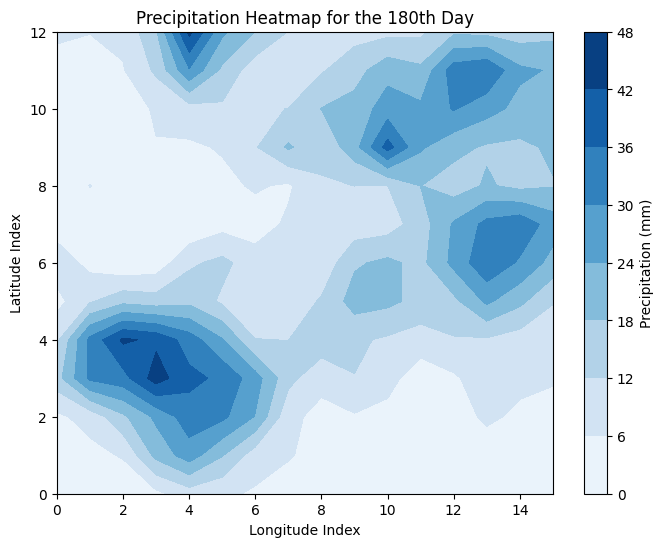

In [2]:
file_path=r'C:\Users\Ankit\Documents\Vedanshi\IISERB-ML-DL-course\PERCDR_0.25deg_2001_2010_precipitation_data.nc'
ds=xr.open_dataset(file_path)
df=ds.to_dataframe().reset_index()
precipi=ds['precip'].values
print("shape of precip:",precipi.shape)

day_180 = precipi[179]
plt.figure(figsize=(8, 6))
plt.contourf(day_180, cmap='Blues')
plt.colorbar(label='Precipitation (mm)')
plt.title('Precipitation Heatmap for the 180th Day')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()


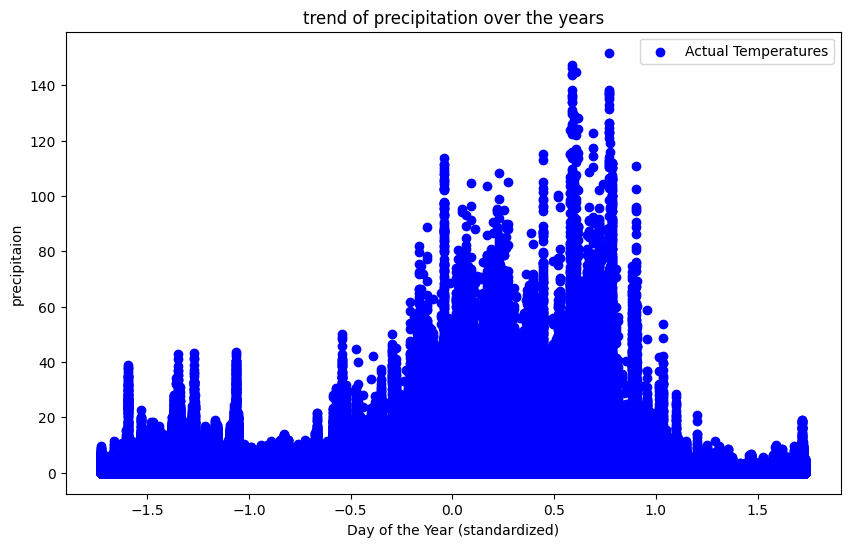

In [3]:
#just plotting to see the variation of precipitation over the years.

y=df[['precip']].values
scale=StandardScaler()
# Extract features and target variable
df['DAY_OF_YEAR'] = df['datetime'].dt.dayofyear
# Use 'DAY_OF_YEAR' as the feature and 'TMAX' (maximum temperature) as the target variable
X = df[['DAY_OF_YEAR']].values  # Feature: day of the year
y = df['precip'].values  # Target: maximum temperature
df1 = df.sort_values('datetime').reset_index(drop=True)
X_scaled = scale.fit_transform(X)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled, y, color='blue', label='Actual Temperatures')
plt.xlabel('Day of the Year (standardized)')
plt.ylabel('precipitaion')
plt.title('trend of precipitation over the years')
plt.legend()
plt.show()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Ankit\Documents\Vedanshi\IISERB-ML-DL-course\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Ankit\Documents\Vedanshi\IISERB-ML-DL-course\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Ankit\Documents\Vedanshi\IISERB-ML-DL-course\.venv\Lib\site-packages\ipykernel\

Convolved result shape: (13, 16)


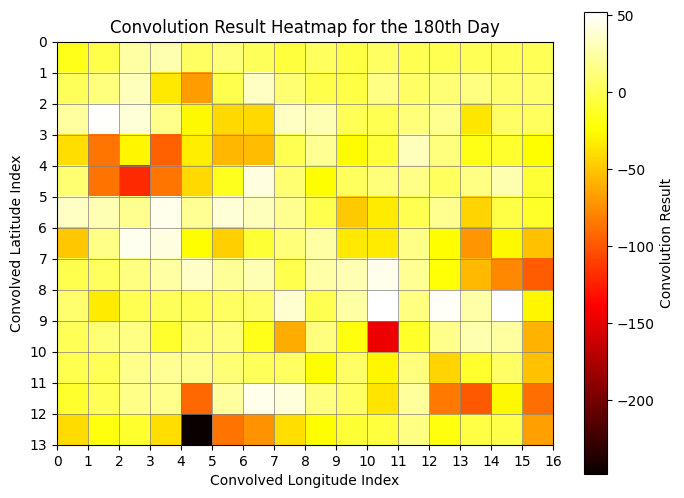

In [4]:
extreme_event_filter = np.array([[1, 1, 1],
                                [1, -8, 1],
                                [1, 1, 1]])

filter_tensor=torch.tensor(extreme_event_filter, dtype=torch.float32)

extreme_threshold = 75

def convolve_stride_pad(image, filter_pattern, stride=1, padding=0):
    if padding > 0:
        image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')

    rows, cols = image.shape
    filter_size = filter_pattern.shape[0]
    output_rows = (rows - filter_size) // stride + 1
    output_cols = (cols - filter_size) // stride + 1
    output = np.zeros((output_rows, output_cols))

    for i in range(0, rows - filter_size + 1, stride):
        for j in range(0, cols - filter_size + 1, stride):
            patch = image[i:i + filter_size, j:j + filter_size]
            output[i // stride, j // stride] = np.sum(patch * filter_pattern)
    
    return output

#we're observing the convolution result for the 180th day of the year to use it to decide the final output dimensions that the fcs would work on.
conv_result = convolve_stride_pad(day_180, extreme_event_filter, stride=1, padding=1)
print("Convolved result shape:", conv_result.shape)

plt.figure(figsize=(8, 6))
plt.imshow(conv_result, cmap='hot', interpolation='nearest')
plt.colorbar(label='Convolution Result')
plt.title('Convolution Result Heatmap for the 180th Day')
plt.xlabel('Convolved Longitude Index')
plt.ylabel('Convolved Latitude Index')

plt.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(-.5, conv_result.shape[1], 1), labels=np.arange(0, conv_result.shape[1] + 1, 1))
plt.yticks(np.arange(-.5, conv_result.shape[0], 1), labels=np.arange(0, conv_result.shape[0] + 1, 1))
plt.gca().set_xticks(np.arange(-.5, conv_result.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, conv_result.shape[0], 1), minor=True)
plt.gca().grid(which='minor', color='grey', linestyle='-', linewidth=0.5)

plt.show()

In [5]:
def label_data(data, filter_pattern, threshold):
    labels = []
    for day in range(data.shape[0]):
        conv_result = convolve_stride_pad(data[day], filter_pattern, stride=1, padding=1)
        max_value = np.max(conv_result)
        label = 1 if max_value > threshold else 0
        labels.append(label)
    return np.array(labels)


Number of extreme event days: 194


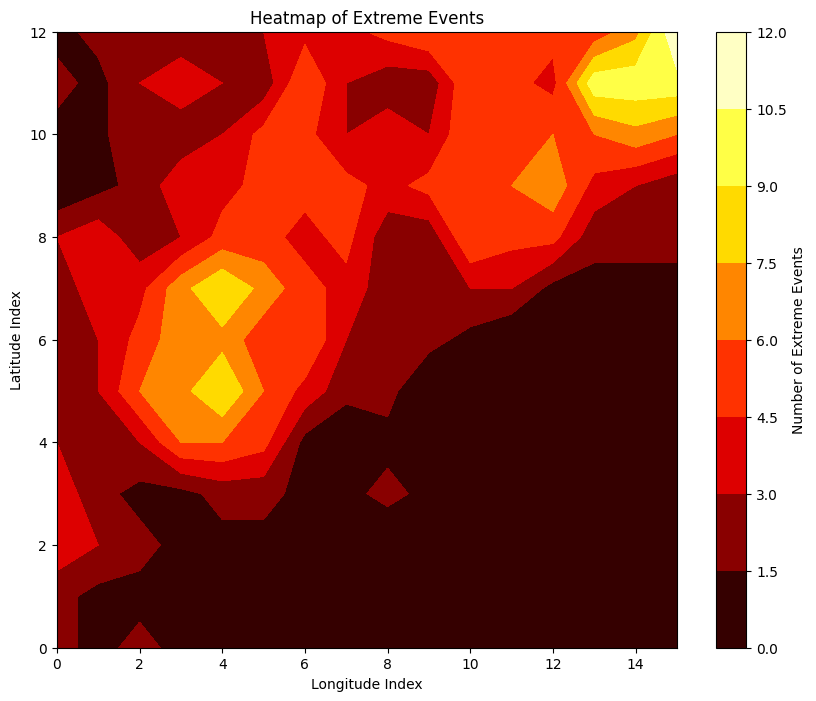

In [6]:
labels = label_data(precipi, extreme_event_filter, extreme_threshold)

# Print the number of extreme event days
print("Number of extreme event days:", np.sum(labels))

# Count the number of extreme events at each grid point
extreme_event_counts = np.zeros((precipi.shape[1], precipi.shape[2]))

for day in range(precipi.shape[0]):
    if labels[day] == 1:
        extreme_event_counts += precipi[day] > extreme_threshold

# Plot the heatmap of extreme events
plt.figure(figsize=(10, 8))
plt.contourf(extreme_event_counts, cmap='hot', levels=10)
plt.colorbar(label='Number of Extreme Events')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.title('Heatmap of Extreme Events')
plt.show()

# pART 2

In [7]:
class PrecipitationDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = sample[np.newaxis, :, :]  # Add channel dimension
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [8]:
train_data = precipi[:2922]  # First 8 years
train_labels = labels[:2922]
test_data = precipi[2922:]  # Last 2 years
test_labels = labels[2922:]
# dataloader instances
train_dataset = PrecipitationDataset(train_data, train_labels)
test_dataset = PrecipitationDataset(test_data, test_labels)#train_dataset is already a tensor
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
#train_loader_tensor=torch.tensor(train_dataset,dtype=torch.float32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#test_loader_tensor=torch.tensor(test_dataset,dtype=torch.float32)

In [9]:
class CNNClassifier(torch.nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(32 * 3 * 4, 64)
        self.fc2 = torch.nn.Linear(64, 1)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 3 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

Epoch [1/20], Loss: 0.3525
Epoch [2/20], Loss: 0.1623
Epoch [3/20], Loss: 0.1169
Epoch [4/20], Loss: 0.0864
Epoch [5/20], Loss: 0.0820
Epoch [6/20], Loss: 0.0629
Epoch [7/20], Loss: 0.0746
Epoch [8/20], Loss: 0.0636
Epoch [9/20], Loss: 0.0575
Epoch [10/20], Loss: 0.0458
Epoch [11/20], Loss: 0.0494
Epoch [12/20], Loss: 0.0344
Epoch [13/20], Loss: 0.0251
Epoch [14/20], Loss: 0.0291
Epoch [15/20], Loss: 0.0186
Epoch [16/20], Loss: 0.0146
Epoch [17/20], Loss: 0.0235
Epoch [18/20], Loss: 0.0205
Epoch [19/20], Loss: 0.0201
Epoch [20/20], Loss: 0.0081
Accuracy: 97.12%
Precision: 0.68
Recall: 0.74
F1 Score: 0.71
Confusion Matrix:
[[683  12]
 [  9  26]]


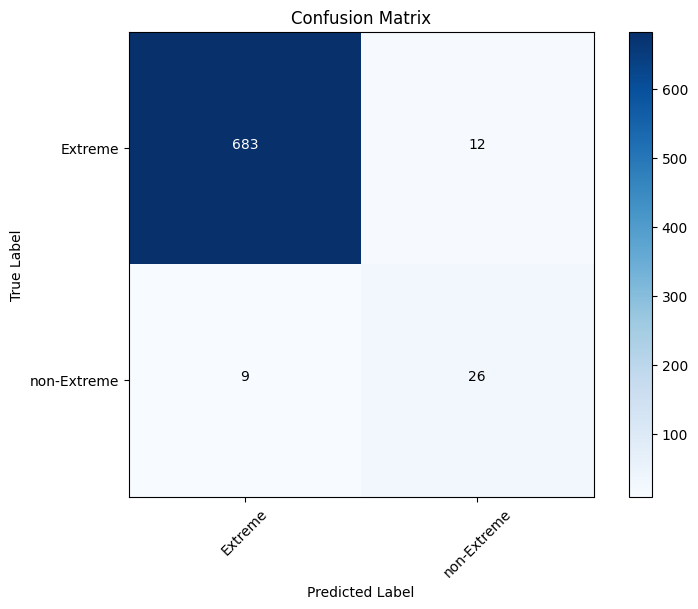

In [10]:
model=CNNClassifier()

# this is the training loop 
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs
        labels = labels.unsqueeze(1)  # Convert labels to shape [batch_size, 1]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model
model.eval()  # Set the model to evaluation mode
test_labels_list = []
pred_labels_list = []

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:
        inputs = inputs  # Ensure correct input shape
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()  # Threshold the sigmoid output to get binary predictions
        test_labels_list.extend(labels.tolist())   # Store true labels
        pred_labels_list.extend(predicted.tolist())    # Store predicted labels

# Convert lists to numpy arrays
test_labels_list = np.array(test_labels_list)
pred_labels_list = np.array(pred_labels_list)

# Calculate and print accuracy
accuracy = accuracy_score(test_labels_list, pred_labels_list)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate and print precision, recall, and F1-score
precision = precision_score(test_labels_list, pred_labels_list)
recall = recall_score(test_labels_list, pred_labels_list)
f1 = f1_score(test_labels_list, pred_labels_list)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels_list, pred_labels_list)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Extreme', 'non-Extreme'], rotation=45)
plt.yticks(tick_marks, ['Extreme', 'non-Extreme'])

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()